# Preliminaries

## Import Packages

In [60]:
#--Basics---------------
import pandas as pd
import numpy as np

#--Data Visualization----
import matplotlib.pyplot as plt
import seaborn as sns

#---Scikit-Learn--------
from sklearn import set_config
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, MaxAbsScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import Ridge, LinearRegression, LogisticRegression, Lasso
from sklearn.impute import SimpleImputer
from sklearn.utils import estimator_html_repr
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA

#---Misc------------------
from mlxtend.feature_selection import SequentialFeatureSelector as MLSeqFeatSelector

## Define Data

In [38]:
data = pd.read_csv(r"ames.csv")
data.to_csv("df.csv")
def numeric_categorical_attributes(data):
    numeric, categorical = ([], [])
    for col in data.columns:
        try:
            data[col].apply(pd.to_numeric)
            numeric.append(col)
        except:
            categorical.append(col)
    return (numeric, categorical)

cols_numeric, cols_categorical = numeric_categorical_attributes(data.drop(columns = ["price"]))
print(cols_numeric)



['Order', 'PID', 'area', 'MS.SubClass', 'Lot.Frontage', 'Lot.Area', 'Overall.Qual', 'Overall.Cond', 'Year.Built', 'Year.Remod.Add', 'Mas.Vnr.Area', 'BsmtFin.SF.1', 'BsmtFin.SF.2', 'Bsmt.Unf.SF', 'Total.Bsmt.SF', 'X1st.Flr.SF', 'X2nd.Flr.SF', 'Low.Qual.Fin.SF', 'Bsmt.Full.Bath', 'Bsmt.Half.Bath', 'Full.Bath', 'Half.Bath', 'Bedroom.AbvGr', 'Kitchen.AbvGr', 'TotRms.AbvGrd', 'Fireplaces', 'Garage.Yr.Blt', 'Garage.Cars', 'Garage.Area', 'Wood.Deck.SF', 'Open.Porch.SF', 'Enclosed.Porch', 'X3Ssn.Porch', 'Screen.Porch', 'Pool.Area', 'Misc.Val', 'Mo.Sold', 'Yr.Sold']


# Data Cleaning

## Handle Missing Values

In [42]:
def clean_nulls(data, drop_cols, cols_numeric, cols_categorical):
    # Drop columns that have many nulls.
    result = data.drop(columns=drop_cols, axis=1)
    new_cols_numeric, new_cols_categorical = [list(set(cols).difference(drop_cols)) for cols in [cols_numeric, cols_categorical]]
    # Impute missing values with the median of the respective column
    for col in new_cols_numeric:
        median_value = data[col].median()
        result[col] = data[col].fillna(median_value)  
    # Impute missing values with the mode of the respective column
    for col in new_cols_categorical:
        result[col] = data[col].fillna(data[col].mode()[0])
    
    return (result, new_cols_numeric, new_cols_categorical)

drop_cols = ['Alley', 'Fireplace.Qu', 'Pool.QC', 'Fence', 'Misc.Feature']
data_1, cols_numeric, cols_categorical = clean_nulls(data, drop_cols, cols_numeric, cols_categorical)



## Encoding

In [58]:
def one_hot_encoding(data, cols_numeric, cols_categorical, target):
    encoder = OneHotEncoder(sparse_output = False).set_output(transform="pandas")
    X_ohe_cat = encoder.fit_transform(data[cols_categorical])
    return pd.concat([X_ohe_cat, data[cols_numeric + [target]]], axis=1)

data_2 = one_hot_encoding(data_1, cols_numeric, cols_categorical, "price")
data_2.to_csv("df2.csv")


## Standard Scaling

In [74]:
def std_scaling(data, target):
    scaler = StandardScaler().set_output(transform="pandas")
    return pd.concat([scaler.fit_transform(data.drop(target, axis=1)), data[target]], axis=1)

data_3 = std_scaling(data_2, "price")
data_3

,Exter.Cond_Ex,Exter.Cond_Fa,Exter.Cond_Gd,Exter.Cond_Po,Exter.Cond_TA,Garage.Cond_Ex,Garage.Cond_Fa,Garage.Cond_Gd,Garage.Cond_Po,Garage.Cond_TA,...,BsmtFin.SF.2,Mo.Sold,X1st.Flr.SF,Order,Lot.Frontage,Year.Built,BsmtFin.SF.1,Bsmt.Unf.SF,MS.SubClass,price
0,-0.064128,-0.152977,-0.337113,-0.032015,0.386614,-0.032015,-0.160967,-0.071734,-0.06929,0.193741,...,-0.293918,-0.448057,1.267003,-1.731460,3.375742,-0.375537,0.431223,-0.269105,-0.877005,215000
1,-0.064128,-0.152977,-0.337113,-0.032015,0.386614,-0.032015,-0.160967,-0.071734,-0.06929,0.193741,...,0.557582,-0.079602,-0.672643,-1.730277,0.514952,-0.342468,0.055760,-0.658319,-0.877005,105000
2,-0.064128,-0.152977,-0.337113,-0.032015,0.386614,-0.032015,-0.160967,-0.071734,-0.06929,0.193741,...,-0.293918,-0.079602,0.432445,-1.729095,0.561850,-0.441674,1.054800,-0.348769,-0.877005,172000
3,-0.064128,-0.152977,-0.337113,-0.032015,0.386614,-0.032015,-0.160967,-0.071734,-0.06929,0.193741,...,-0.293918,-0.816513,2.425687,-1.727913,1.124628,-0.110988,1.366588,1.105661,-0.877005,244000
4,-0.064128,-0.152977,-0.337113,-0.032015,0.386614,-0.032015,-0.160967,-0.071734,-0.06929,0.193741,...,-0.293918,-1.184969,-0.590974,-1.726731,0.233563,0.848000,0.764969,-0.961040,0.061285,189900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,-0.064128,-0.152977,-0.337113,-0.032015,0.386614,-0.032015,-0.160967,-0.071734,-0.06929,0.193741,...,-0.293918,-1.184969,-0.399561,1.726731,-1.501671,0.418109,0.826448,-0.854064,0.530430,142500
2926,-0.064128,-0.152977,-0.337113,-0.032015,0.386614,-0.032015,-0.160967,-0.071734,-0.06929,0.193741,...,1.621958,-0.079602,-0.657330,1.727913,-0.047827,0.385040,-0.310920,-0.728878,-0.877005,131000
2927,-0.064128,-0.152977,-0.337113,-0.032015,0.386614,-0.032015,-0.160967,-0.071734,-0.06929,0.193741,...,-0.293918,0.288854,-0.483783,1.729095,-0.329216,0.682657,-0.231876,0.035893,0.647716,132000
2928,-0.064128,-0.152977,-0.337113,-0.032015,0.386614,-0.032015,-0.160967,-0.071734,-0.06929,0.193741,...,0.433405,-0.816513,0.585575,1.730277,0.374257,0.087423,1.379762,-0.829026,-0.877005,170000


# Feature Selection

Our processed data has 77 variables and 2930 observations. we want to perform feature selection on the data in order to determine which variables are most significant for different models based on the accuracy of the models. This will enable us to do better predictions for your organization in terms of determining the housing prices.

## Find Features With Highest Correlation to Target

In [24]:
def top_corr_features(data, target, num_features):
    #Feature selection based on correlation matrix value
    correlation_matrix = data.corr()
    top_correlations = correlation_matrix[target].abs().nlargest(num_features)
    return top_correlations.index

print("The top 10 most correlated attributes with respect \
to price are \n{}.".format("\n".join(list(top_corr_features(data_2, "price", 10)))))

The top 10 most correlated attributes with respect to price are 
price
Garage.Cars
Garage.Area
Total.Bsmt.SF
Bsmt.Qual_Ex
Garage.Finish_Unf
Garage.Yr.Blt
Mas.Vnr.Area
Bsmt.Qual_TA
BsmtFin.SF.1.


## Forward Subset Selection (Fatima)

In [ ]:
def feat_selection_feats(data, target, forward, k_features):
    X_train, X_test, Y_train, Y_test = train_test_split(data.drop([target], axis=1), data[target], test_size=0.3, random_state=1)
    feat_select = MLSeqFeatSelector(LinearRegression(), k_features=k_features, forward=forward, floating=False,
                                                    verbose=2, scoring='r2', cv=10)
    feat_select.fit(X_train, Y_train)
    return feat_select.k_feature_names_


In [ ]:
forward_features = feat_selection_feats(data_3, "price", True, 38)

The best 10 features for our Linear regression Model as returned by Forward Selection are shown above. They are the features with the most significant impact according to our Forward Selection Algorithm

## Backward Subset Selection (Fatima)

In [79]:
backward_features = feat_selection_feats(data_3, "price", False, 10)

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   39.1s

STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

The top 10 best features with the most significant as returned by our Backward Subset Selection is shown above. More than 90% of the features returned by Backward Selection are in the Forward Selection. 

## Forward Subset Selection (Ian)

In [84]:
def feat_selection_feats2(data, target, forward, threshold):
    direction = "forward" if forward else "backward"
    feat_select = SequentialFeatureSelector(estimator=LinearRegression(), direction=direction, tol=threshold).set_output(transform="pandas")
    return feat_select.fit_transform(data.drop(target, axis=1), data[target]).columns

In [83]:
feat_selection_feats2(data_3, "price", True, .001)

Index(['Land.Contour_Bnk', 'Bldg.Type_2fmCon', 'Kitchen.Qual_Ex',
       'Bsmt.Qual_Ex', 'Neighborhood_Crawfor', 'Neighborhood_GrnHill',
       'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_Somerst',
       'Neighborhood_StoneBr', 'Exter.Qual_Ex', 'Bsmt.Exposure_Av',
       'Bsmt.Exposure_Gd', 'Roof.Matl_WdShngl', 'area', 'Garage.Cars',
       'Overall.Cond', 'Fireplaces', 'Overall.Qual', 'Screen.Porch',
       'Year.Built', 'BsmtFin.SF.1', 'MS.SubClass'],
      dtype='object')

## Backward Selection (Ian)

In [86]:
feat_selection_feats2(data_3, "price", False, 0.001)

KeyboardInterrupt: 

# Data Regularization

We have decided to use the union of the best 10 predictors returned by both forward and backward subset selection to fit a simple linear model. 

In [ ]:
predictors_to_use = ['area', 'MS.SubClass', 'Overall.Qual', 'Year.Built', 
                     'Year.Remod.Add', 'Mas.Vnr.Area', 'Bsmt.Full.Bath', 
                     'Fireplaces', 'Garage.Cars', 'Screen.Porch', 'BsmtFin.SF.1']

# Data Visualizations

## See What Columns Have Too Many Nulls

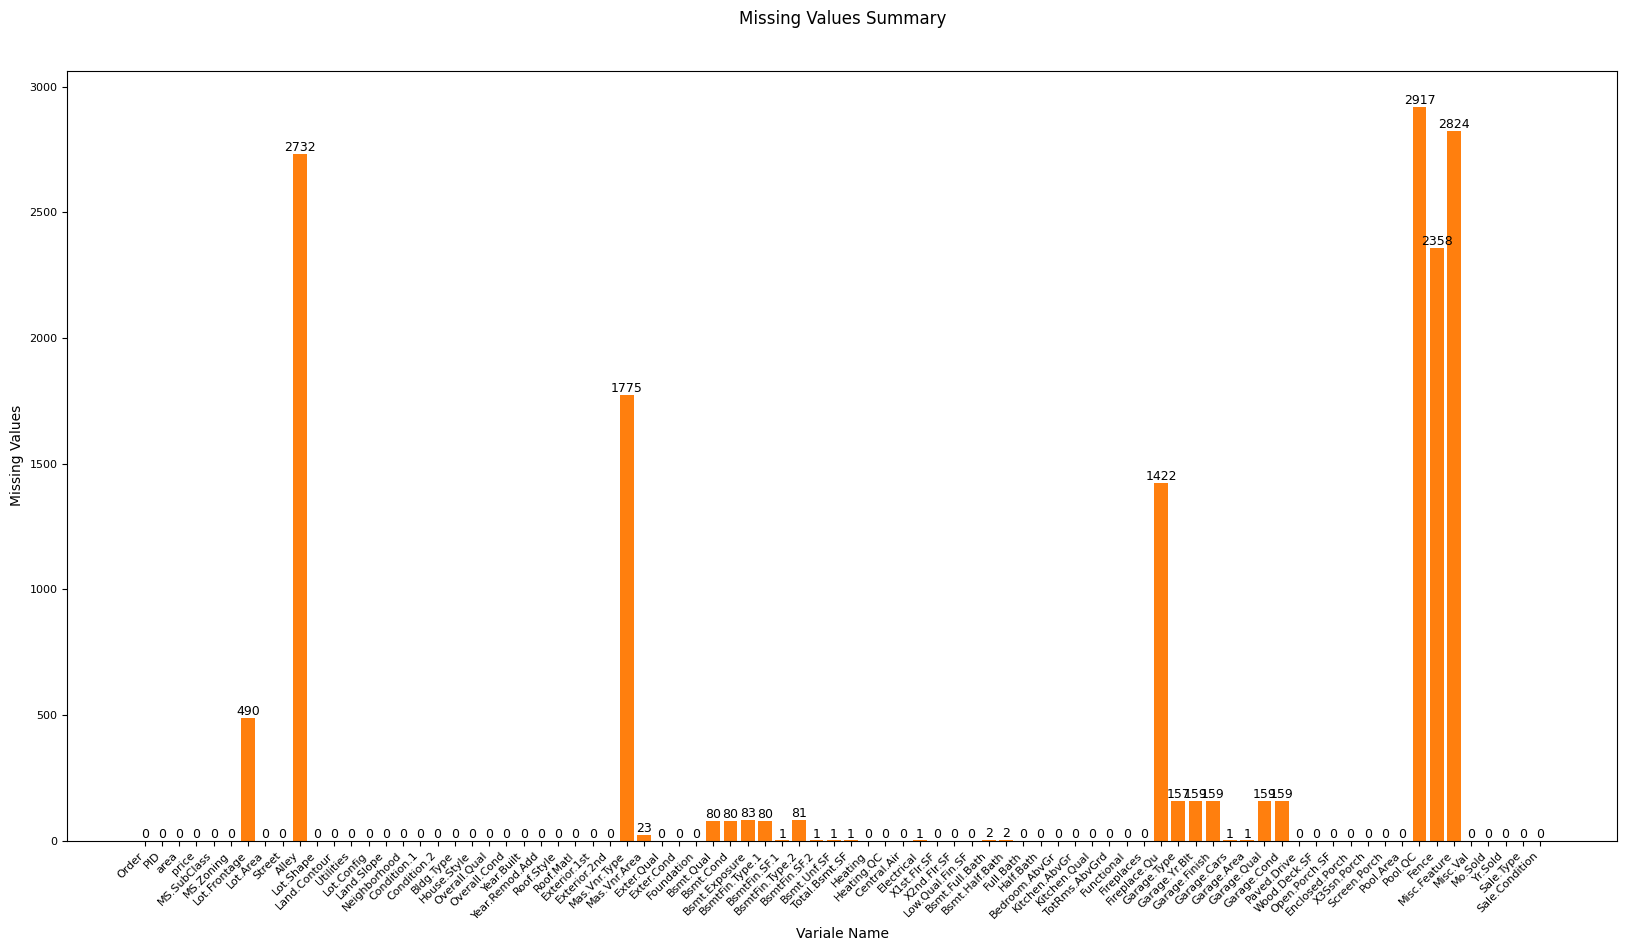

In [11]:
# Check for missing values
missing_values = data.isnull().sum()

# Creat the figure and specify the size
plt.figure(figsize=(20, 10))

# Create the bar chart
bars = plt.bar(missing_values.index, missing_values.values)
plt.bar(missing_values.index, missing_values.values)
plt.xlabel('Variale Name')
plt.ylabel('Missing Values')
plt.title('Missing Values Summary', y=1.05)

# Rotate x-axis labels for better visibility and reduce font size
plt.xticks(rotation=45, ha='right', fontsize=8)  # Adjust the rotation angle and font size as needed
plt.yticks(fontsize=8)

# Add the actual values on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', color='black', fontsize=9)

# Save the plot as an image (PNG format in this example)
#plt.savefig('Ams_missing_values_plot.png', bbox_inches='tight')

plt.show()

The column with missing values percentage[Alley= 93%, Fireplace.Qu= 49%, Pool.QC= 99.6% Fence=80%, Misc.Feature=96.4%]

## Correlation Matrix

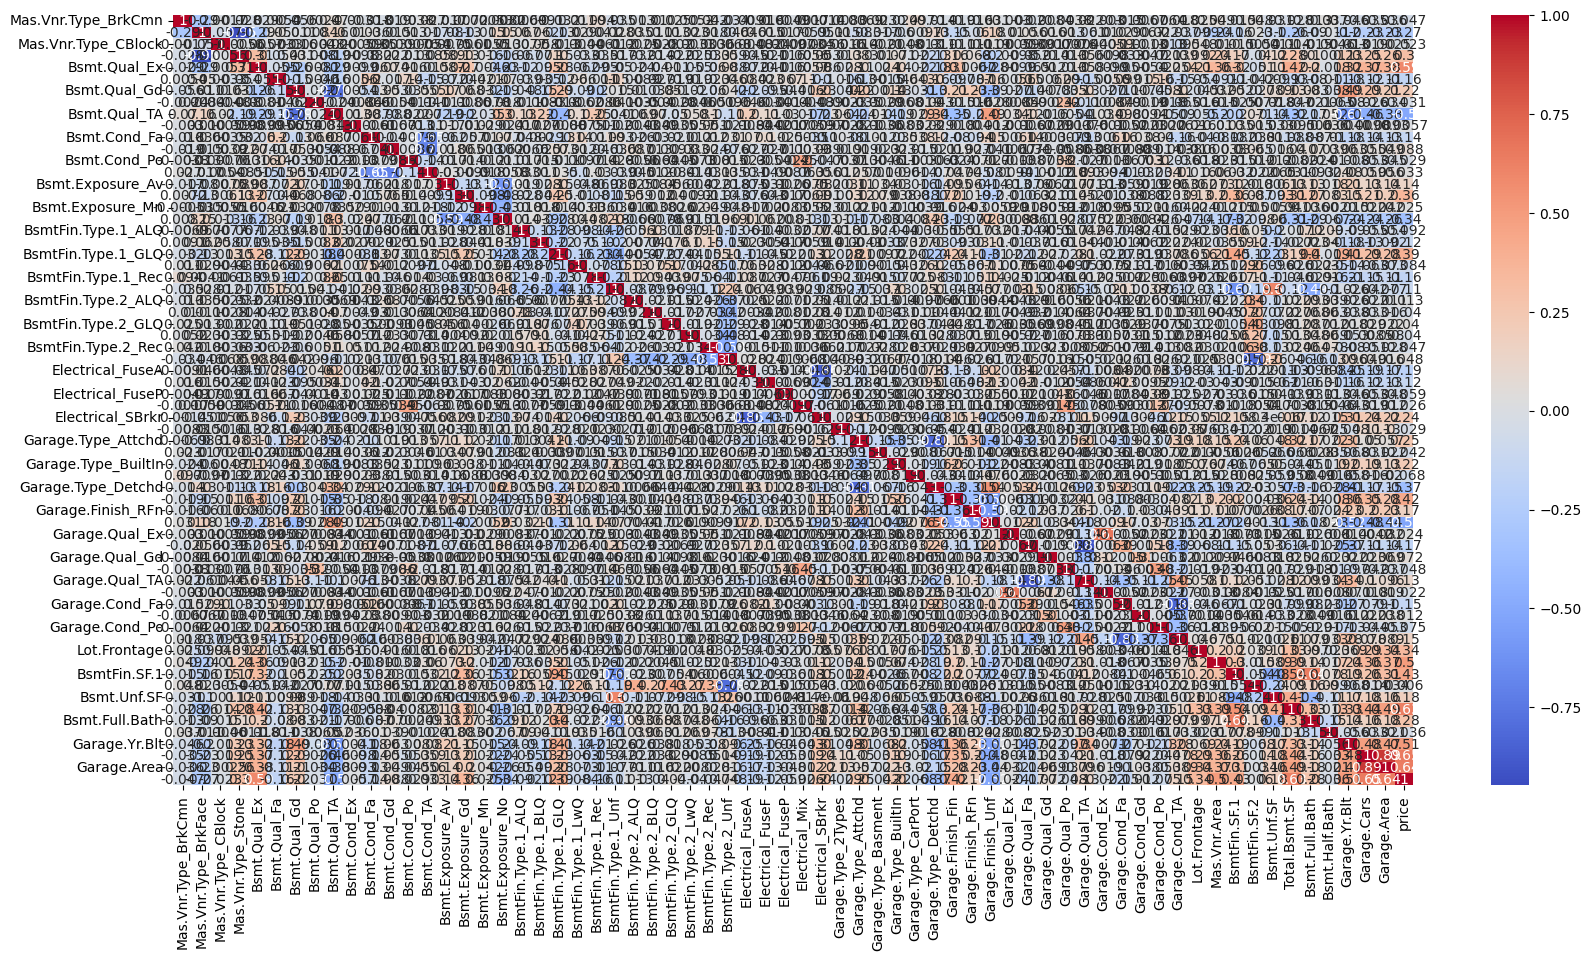

In [16]:
# Calculate the correlation matrix
correlation_matrix = data_2.corr()
# Create a heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.show()

## Scatterplots and Boxplots to See Correlations

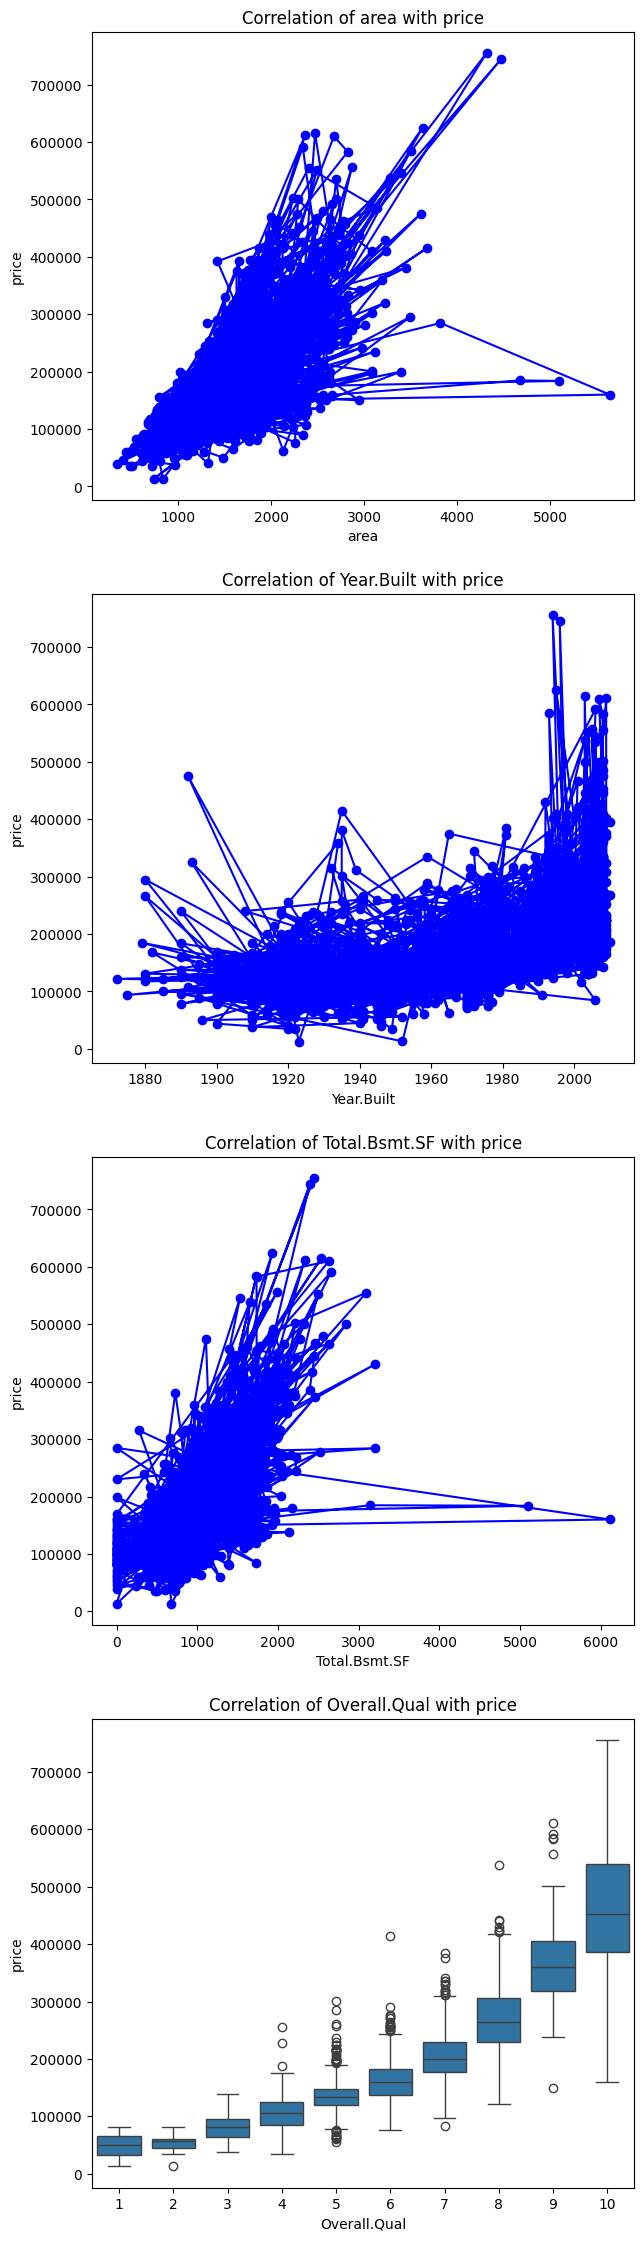

In [57]:
def scatterplots(data, features_num, features_cat, target, size = 7):
    n_num, n_cat = (len(features_num), len(features_cat))
    n = n_num + n_cat
    plt.figure(1, figsize = (size, size * n))
    for i in range(n_num):
        ax = plt.subplot(n, 1, i + 1)
        ax.title.set_text("Correlation of {} with {}".format(features_num[i], target))
        plt.plot(data[features_num[i]], data[target], **{'color': 'blue', 'marker': 'o'})
        plt.xlabel(features_num[i])
        plt.ylabel(target)
    for i in range(n_cat):
        ax = plt.subplot(n, 1, i + 1 + n_num)
        ax.title.set_text("Correlation of {} with {}".format(features_cat[i], target))
        df = pd.concat([data[features_cat[i]], data[target]], axis=1)
        sns.boxplot(x = features_cat[i], y = target, data = df, ax = ax)
        plt.xlabel(features_cat[i])
        plt.ylabel(target)
    plt.show()

scatterplots(data_2, ["area", "Year.Built", "Total.Bsmt.SF"], ["Overall.Qual"], "price")

For Overall.Qual values are
      10 Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average
       5	Average
       4	Below Average
       3	Fair
       2	Poor
       1	Very Poor.

  From this we can see the very excellent quality of houses has the most price